# Data Checks

- Schema checks: Making sure that only the columns that are expected are provided.

- Datum checks:
    - Looking for missing values
    - Ensuring that expected value ranges are correct

- Statistical checks:
    - Visual check of data distributions.
    - Correlations between columns.
    - Statistical distribution checks.

# Roles in Data Analysis

- **Data Provider:** Someone who's collected and/or curated the data.
- **Data Analyst:** The person who is analyzing the data.

Sometimes they're the same person; at other times they're not. Tasks related to testing can often be assigned to either role, but there are some tasks more naturally suited to each.

# Schema Checks

Schema checks are all about making sure that the data columns that you want to have are all present, and that they have the expected data types.

The way data are provided to you should be in two files. The first file is the actual data matrix. The second file should be a metadata specification file, minimally containing the name of the CSV file it describes, and the list of columns present. Why the duplication? The list of columns is basically an implicit contract between your data provider and you, and provides a verifiable way of describing the data matrix's columns.

We're going to use a few datasets from Boston's open data repository. Let's first take a look at Boston's annual budget data, while pretending we're the person who curated the data, the "data provider".

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## A bit of basic `pandas`

Let's first start by reading in the CSV file as a `pandas.DataFrame()`.

In [2]:
import pandas as pd
df = pd.read_csv('data/boston_budget.csv')
df.head()

,Fiscal Year,Service (Cabinet),Department,Program #,Program,Expense Type,ACCT #,Expense Category (Account),Fund,Amount
0,2014,Mayors Cabinet,Mayor's Office,111100,Administration,Personnel Services,51000,Permanent Employees,General Fund,$797875.00
1,2014,Mayors Cabinet,Mayor's Office,111100,Administration,Personnel Services,51100,Emergency Employees,General Fund,$7823.00
2,2014,Mayors Cabinet,Mayor's Office,111100,Administration,Personnel Services,51600,Unemployment Compensation,General Fund,$16820.00
3,2014,Mayors Cabinet,Mayor's Office,111100,Administration,Contractual Services,52100,Communications,General Fund,$47462.00
4,2014,Mayors Cabinet,Mayor's Office,111100,Administration,Contractual Services,52700,Repairs & Service To Equipment,General Fund,$5171.00


To get the columns of a DataFrame object `df`, call `df.columns`. This is a list-like object that can be iterated over.

In [3]:
df.columns

Index(['Fiscal Year', 'Service (Cabinet)', 'Department', 'Program #',
       'Program', 'Expense Type', 'ACCT #', 'Expense Category (Account)',
       'Fund', 'Amount'],
      dtype='object')

## YAML Files

Describe data in a human-friendly & computer-readable format. The `environment.yml` file in your downloaded repository is also a YAML file, by the way!

Structure:

```yaml
key1: value
key2:
- value1
- value2
- subkey1:
    - value3
```

Example YAML-formatted schema:

```yaml
filename: boston_budget.csv
column_names:
- "Fiscal Year"
- "Service (cabinet)"
- "Department"
- "Program #"
...
- "Fund"
- "Amount"
```

YAML-formatted text can be read as dictionaries.

In [4]:
spec = """
filename: boston_budget.csv
columns:
- "Fiscal Year"
- "Service (Cabinet)"
- "Department"
- "Program #"
- "Program"
- "Expense Type"
- "ACCT #"
- "Expense Category (Account)"
- "Fund"
- "Amount"
"""

In [6]:
import yaml
metadata = yaml.load(spec)
metadata

/home/dell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'filename': 'boston_budget.csv',
 'columns': ['Fiscal Year',
  'Service (Cabinet)',
  'Department',
  'Program #',
  'Program',
  'Expense Type',
  'ACCT #',
  'Expense Category (Account)',
  'Fund',
  'Amount']}

You can also take dictionaries, and return YAML-formatted text.

In [8]:
print(yaml.dump(metadata))

columns: [Fiscal Year, Service (Cabinet), Department, 'Program #', Program, Expense
    Type, 'ACCT #', Expense Category (Account), Fund, Amount]
filename: boston_budget.csv



By having things YAML formatted, you preserve human-readability and computer-readability simultaneously. 

Providing metadata should be something already done when doing analytics; YAML-format is a strong suggestion, but YAML schema will depend on use case.

Let's now switch roles, and pretend that we're on side of the "analyst" and are no longer the "data provider". 

How would you check that the columns match the spec? Basically, check that every element in `df.columns` is present inside the `metadata['columns']` list.

## Exercise

Inside `test_datafuncs.py`, write a utility function, `check_schema(df, meta_columns)` that tests whether every column in a DataFrame is present in some metadata spec file. It should accept two arguments:

- `df`: a `pandas.DataFrame`
- `meta_columns`: A list of columns from the metadata spec.

```python

def check_schema(df, meta_columns):
    for col in df.columns:
        assert col in meta_columns, f'"{col}" not in metadata column spec'
```

In your test file, outside the function definition, write another test function, `test_budget_schemas()`, explicitly runs a test for just the budget data.

```python
def test_budget_schemas():
    columns = read_metadata('data/metadata_budget.yml')['columns']
    df = pd.read_csv('data/boston_budget.csv')

    check_schema(df, columns)
```

Now, run the test. Do you get the following error? Can you spot the error?

```bash
    def check_schema(df, meta_columns):
        for col in df.columns:
>           assert col in meta_columns, f'"{col}" not in metadata column spec'
E           AssertionError: " Amount" not in metadata column spec
E           assert ' Amount' in ['Fiscal Year', 'Service (Cabinet)', 'Department', 'Program #', 'Program', 'Expense Type', ...]

test_datafuncs_soln.py:63: AssertionError
=================================== 1 failed, 7 passed in 0.91 seconds ===================================
```

If there is even a slight mis-spelling, this kind of check will help you pinpoint where that is. Note how the "Amount" column is spelled with an extra space. 

At this point, I would contact the data provider to correct errors like this.

It is a logical practice to keep one schema spec file per table provided to you. However, it is also possible to take advantage of YAML "documents" to keep multiple schema specs inside a single YAML file. 

The choice is yours - in cases where there are a lot of data files, it may make sense (for the sake of file-system sanity) to keep all of the specs in multiple files that represent logical groupings of data.

## Exercise: Write `YAML` metadata spec.

Put yourself in the shoes of a data provider. Take the `boston_ei.csv` file in the `data/` directory, and make a schema spec file for that file.

In [25]:
spec_ei = """
filename: boston_ei.csv
columns: 
- Year
- Month
- logan_passengers
- logan_intl_flights
- hotel_occup_rate
- hotel_avg_daily_rate
- total_jobs
- unemp_rate
- labor_force_part_rate
- pipeline_unit
- pipeline_total_dev_cost
- pipeline_sqft
- pipeline_const_jobs
- foreclosure_pet
- foreclosure_deeds
- med_housing_price
- housing_sales_vol
- new_housing_const_permits
- new-affordable_housing_permits
"""

In [26]:
import yaml
metadata_ei = yaml.load(spec_ex)
metadata_ei

/home/dell/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


{'filename': 'boston_ei.csv',
 'columns': ['Year',
  'Month',
  'logan_passengers',
  'logan_intl_flights',
  'hotel_occup_rate',
  'hotel_avg_daily_rate',
  'total_jobs',
  'unemp_rate',
  'labor_force_part_rate',
  'pipeline_unit',
  'pipeline_total_dev_cost',
  'pipeline_sqft',
  'pipeline_const_jobs',
  'foreclosure_pet',
  'foreclosure_deeds',
  'med_housing_price',
  'housing_sales_vol',
  'new_housing_const_permits',
  'new-affordable_housing_permits']}

In [27]:
print(yaml.dump(metadata_ei))

columns:
- Year
- Month
- logan_passengers
- logan_intl_flights
- hotel_occup_rate
- hotel_avg_daily_rate
- total_jobs
- unemp_rate
- labor_force_part_rate
- pipeline_unit
- pipeline_total_dev_cost
- pipeline_sqft
- pipeline_const_jobs
- foreclosure_pet
- foreclosure_deeds
- med_housing_price
- housing_sales_vol
- new_housing_const_permits
- new-affordable_housing_permits
filename: boston_ei.csv



## Exercise: Write test for metadata spec.

Next, put yourself in the shoes of a data analyst. Take the schema spec file and write a test for it.

In [31]:
def check_schema(df, schema):
    for col in df.columns:
        assert col in metadata_ei, f'"{col}" not in metadata_ei column spec'

In [32]:
def test_budget_ei_schemas():
    columns = yaml.load(open('data/metadata_ei.yml'), Loader=yaml.FullLoader)['columns']
    df = pd.read_csv('data/boston_ei.csv')
    check_schema(df, columns)

In [33]:
test_budget_ei_schemas()

AssertionError: "Year" not in metadata_ei column spec

## Exercise: Auto YAML Spec.

Inside `datafuncs.py`, write a function with the signature `autospec(handle)` that takes in a file path, and does the following:

- Create a dictionary, with two keys:
    - a "filename" key, whose value only records the filename (and not the full file path),
    - a "columns" key, whose value records the list of columns in the dataframe.
- Converts the dictionary to a YAML string
- Writes the YAML string to disk.

## Optional Exercise: Write meta-test

Now, let's go "meta". Write a "meta-test" that ensures that every CSV file in the `data/` directory has a schema file associated with it. (The function need not check each schema.) Until we finish filling out the rest of the exercises, this test can be allowed to fail, and we can mark it as a test to skip by marking it with an `@skip` decorator:

```python
@pytest.mark.skip(reason="no way of currently testing this")
def test_my_func():
    ...
```

## Notes

- The point here is to have a trusted copy of schema apart from data file. YAML not necessarily only way!
- If no schema provided, manually create one; this is exploratory data analysis anyways - no effort wasted!

# Datum Checks

Now that we're done with the schema checks, let's do some sanity checks on the data as well. This is my personal favourite too, as some of the activities here overlap with the early stages of exploratory data analysis.

We're going to switch datasets here, and move to a 'corrupted' version of the Boston Economic Indicators dataset. Its file path is: `./data/boston_ei-corrupt.csv`.

In [34]:
import pandas as pd
import seaborn as sns
sns.set_style('white')
%matplotlib inline

df = pd.read_csv('data/boston_ei-corrupt.csv')
df.head()

,Year,Month,logan_passengers,logan_intl_flights,hotel_occup_rate,hotel_avg_daily_rate,total_jobs,unemp_rate,labor_force_part_rate,pipeline_unit,pipeline_total_dev_cost,pipeline_sqft,pipeline_const_jobs,foreclosure_pet,foreclosure_deeds,med_housing_price,housing_sales_vol,new_housing_const_permits,new-affordable_housing_permits
0,2013,1,2019662.0,2986.0,0.572,158.925868,0.0,0.071,0.594,329.0,80000000.0,313107.0,241.600,44.0,11,380000,405,534,134
1,2013,2,1878731.0,2587.0,0.645,165.497062,0.0,0.063,0.591,557.0,360700000.0,1001911.0,1089.314,50.0,10,359500,332,196,13
2,2013,3,2469155.0,3250.0,0.819,187.450000,0.0,0.061,0.591,803.0,343200000.0,820556.0,1036.464,6.0,6,400000,479,12,0
3,2013,4,2551246.0,3408.0,0.855,233.435374,0.0,0.061,0.593,325.0,150000000.0,350000.0,453.000,14.0,8,403000,558,91,24
4,2013,5,2676291.0,3240.0,0.858,237.890210,0.0,0.069,59.700,122.0,222200000.0,457374.0,671.044,12.0,4,425500,809,63,0


### Demo: Visual Diagnostics

We can use a package called `missingno`, which gives us a quick visual view of the completeness of the data. This is a good starting point for deciding whether you need to manually comb through the data or not.

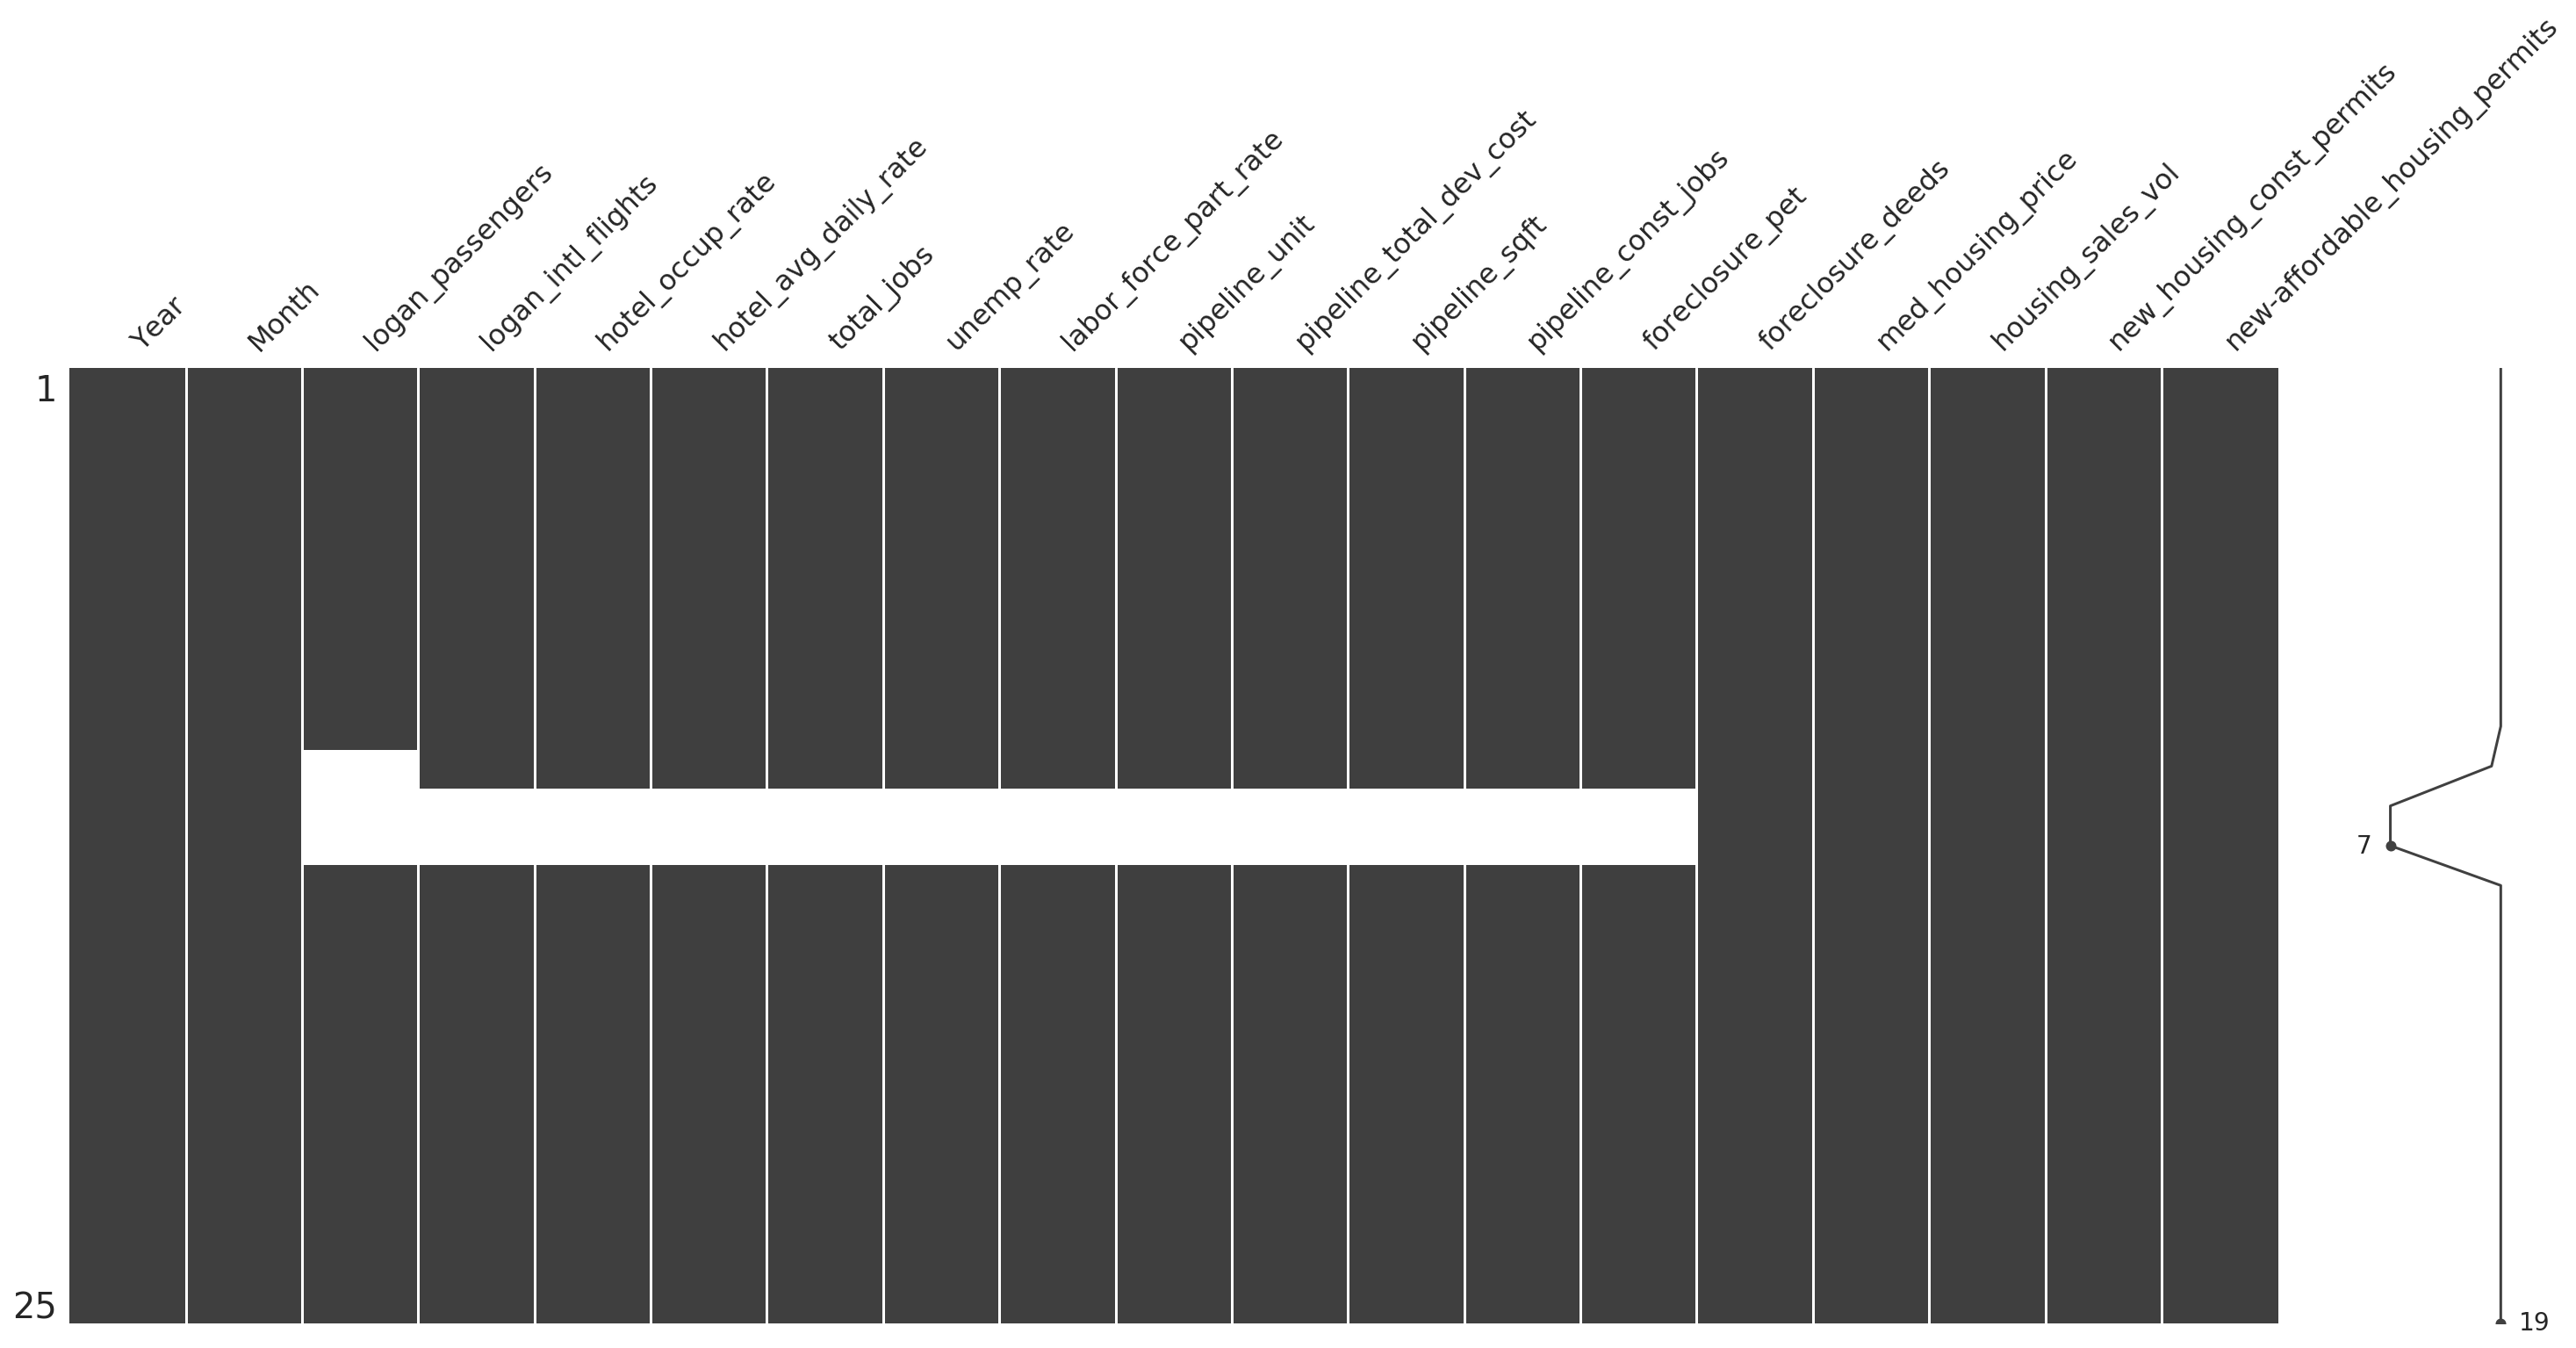

In [38]:
# First, we check for missing data.
import missingno as msno
msno.matrix(df)

Immediately it's clear that there's a number of rows with empty values! Nothing beats a quick visual check like this one.

We can get a table version of this using another package called `pandas_summary`. 

In [41]:
# We can do the same using pandas-summary.
from pandas_summary import DataFrameSummary

dfs = DataFrameSummary(df)
dfs.summary()

,Year,Month,logan_passengers,logan_intl_flights,hotel_occup_rate,hotel_avg_daily_rate,total_jobs,unemp_rate,labor_force_part_rate,pipeline_unit,pipeline_total_dev_cost,pipeline_sqft,pipeline_const_jobs,foreclosure_pet,foreclosure_deeds,med_housing_price,housing_sales_vol,new_housing_const_permits,new-affordable_housing_permits
count,25,25,22,23,23,23,23,23,23,23,23,23,23,23,25,25,25,25,25
mean,2013.56,6.28,2.48736e+06,3137,0.792652,221.198,0,0.06,3.1467,408.957,3.55608e+08,822970,1074.07,26.0435,8.12,444947,802.8,262.68,50.28
std,0.583095,3.62307,654518,779.062,0.203369,61.6769,0,0.015533,12.3288,366.335,5.01302e+08,946010,1513.88,12.3232,3.11341,31730.9,594.514,212.974,52.2051
min,2013,1,0,0,0,0,0,0,0,0,0,0,0,6,2,359500,332,0,0
25%,2013,3,2.43381e+06,3055.5,0.787,193.05,0,0.056,0.596,132,1.15e+08,331554,348,15,6,429000,459,70,14
50%,2014,6,2.55582e+06,3240,0.881,237.89,0,0.062,0.6,296,1.5175e+08,457374,458,28,8,450000,570,250,38
75%,2014,9,2.81848e+06,3426,0.906,257.559,0,0.069,0.6115,702.5,3.5195e+08,920577,1062.89,35,10,470000,864,399,69
max,2015,12,3.13709e+06,4000,0.931,288.5,0,0.078,59.7,1228,2.3255e+09,4.64204e+06,7023.01,50,14,480000,2508,712,185
counts,25,25,22,23,23,23,23,23,23,23,23,23,23,23,25,25,25,25,25
uniques,3,12,20,21,22,23,1,16,17,21,22,22,22,19,9,20,24,24,20


`dfs.summary()` returns a Pandas DataFrame; this means we can write tests for data completeness!

## Exercise: Test for data completeness.

Write a test named `check_data_completeness(df)` that takes in a DataFrame and confirms that there's no missing data from the `pandas-summary` output. Then, write a corresponding `test_boston_ei()` that tests the schema for the Boston Economic Indicators dataframe.

```python
# In test_datafuncs.py
from pandas_summary import DataFrameSummary
def check_data_completeness(df):
    
    df_summary = DataFrameSummary(df).summary()
    for col in df_summary.columns:
        assert df_summary.loc['missing', col] == 0, f'{col} has missing values'
        
def test_boston_ei():
    df = pd.read_csv('data/boston_ei.csv')
    check_data_completeness(df)
```

## Exercise: Test for value correctness.

In the Economic Indicators dataset, there are four "rate" columns: `['labor_force_part_rate', 'hotel_occup_rate', 'hotel_avg_daily_rate', 'unemp_rate']`, which must have values between 0 and 1.

Add a utility function to `test_datafuncs.py`, `check_data_range(data, lower=0, upper=1)`, which checks the range of the data such that:
- `data` is a list-like object.
- `data <= upper`
- `data >= lower`
- `upper` and `lower` have default values of 1 and 0 respectively.

Then, add to the `test_boston_ei()` function tests for each of these four columns, using the `check_data_range()` function.

```python
# In test_datafuncs.py
def check_data_range(data, lower=0, upper=1):
    assert min(data) >= lower, f"minimum value less than {lower}"
    assert max(data) <= upper, f"maximum value greater than {upper}"

def test_boston_ei():
    df = pd.read_csv('data/boston_ei.csv')
    check_data_completeness(df)

    zero_one_cols = ['labor_force_part_rate', 'hotel_occup_rate',
                     'hotel_avg_daily_rate', 'unemp_rate']
    for col in zero_one_cols:
        check_data_range(df['labor_force_part_rate'])
```

## Distributions

Most of what is coming is going to be a demonstration of the kinds of tools that are potentially useful for you. Feel free to relax from coding, as these aren't necessarily obviously automatable.

### Numerical Data

We can take the EDA portion further, by doing an empirical cumulative distribution plot for each data column.

In [ ]:
import numpy as np
def compute_dimensions(length):
    """
    Given an integer, compute the "square-est" pair of dimensions for plotting.
    
    Examples:
    - length: 17 => rows: 4, cols: 5
    - length: 14 => rows: 4, cols: 4
    
    This is a utility function; can be tested separately.
    """
    sqrt = np.sqrt(length)
    floor = int(np.floor(sqrt))
    ceil = int(np.ceil(sqrt))
    
    if floor ** 2 >= length:
        return (floor, floor)
    elif floor * ceil >= length:
        return (floor, ceil)
    else:
        return (ceil, ceil)
    
compute_dimensions(length=17)

assert compute_dimensions(17) == (4, 5)
assert compute_dimensions(16) == (4, 4)
assert compute_dimensions(15) == (4, 4)
assert compute_dimensions(11) == (3, 4)

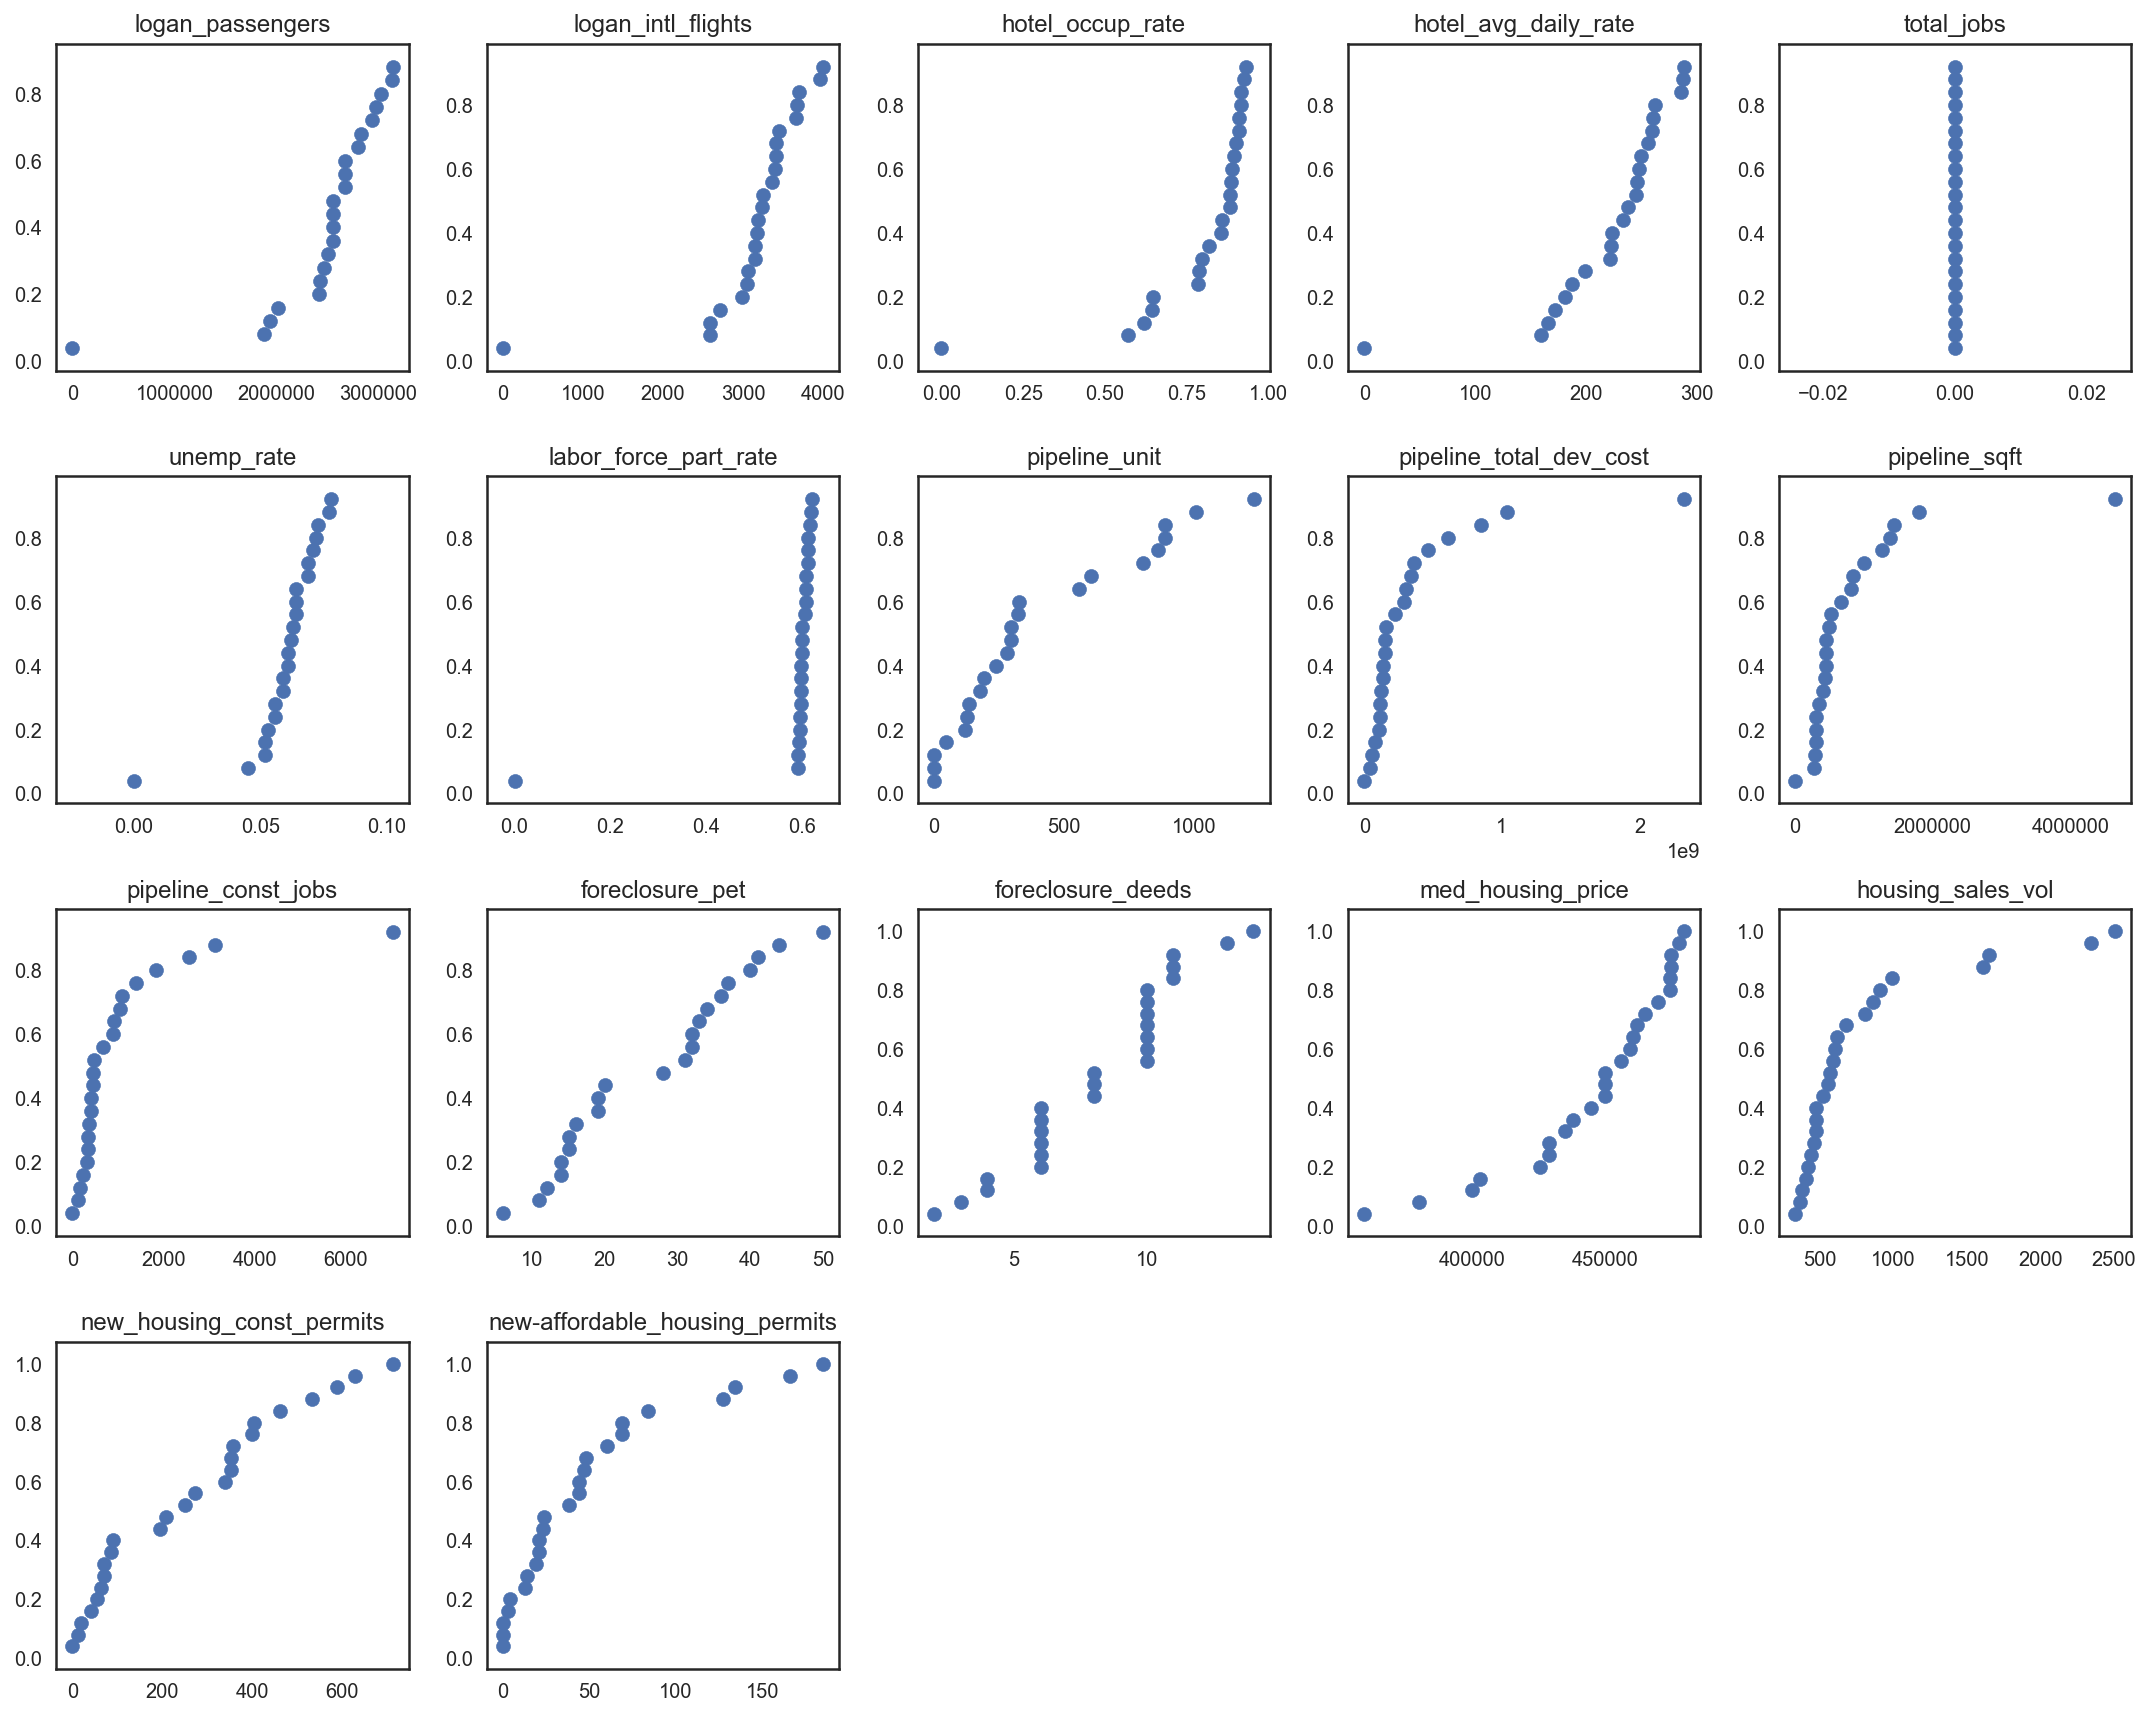

In [14]:
# Next, let's visualize the empirical CDF for each column of data.
import matplotlib.pyplot as plt

def empirical_cumdist(data, ax, title=None):
    """
    Plots the empirical cumulative distribution of values.
    """
    x, y = np.sort(data), np.arange(1, len(data)+1) / len(data)
    ax.scatter(x, y)
    ax.set_title(title)
    
data_cols = [i for i in df.columns if i not in ['Year', 'Month']]
n_rows, n_cols = compute_dimensions(len(data_cols))

fig = plt.figure(figsize=(n_cols*3, n_rows*3))
from matplotlib.gridspec import GridSpec
gs = GridSpec(n_rows, n_cols)
for i, col in enumerate(data_cols):
    ax = plt.subplot(gs[i])
    empirical_cumdist(df[col], ax, title=col)
    
plt.tight_layout()
plt.show()

It's often a good idea to **standardize** numerical data (that aren't count data). The term **standardize** often refers to the statistical procedure of subtracting the mean and dividing by the standard deviation, yielding an empirical distribution of data centered on 0 and having standard deviation of 1.

### Exercise

Write a test for a function that standardizes a column of data. Then, write the function.

**Note:** This function is also implemented in the `scikit-learn` library as part of their `preprocessing` module. However, in case an engineering decision that you make is that you don't want to import an entire library just to use one function, you can re-implement it on your own.

```python
def standard_scaler(x):
    return (x - x.mean()) / x.std()

def test_standard_scaler(x):
    std = standard_scaler(x)
    assert np.allclose(std.mean(), 0)
    assert np.allclose(std.std(), 1)
```

### Exercise

Now, plot the grid of standardized values.

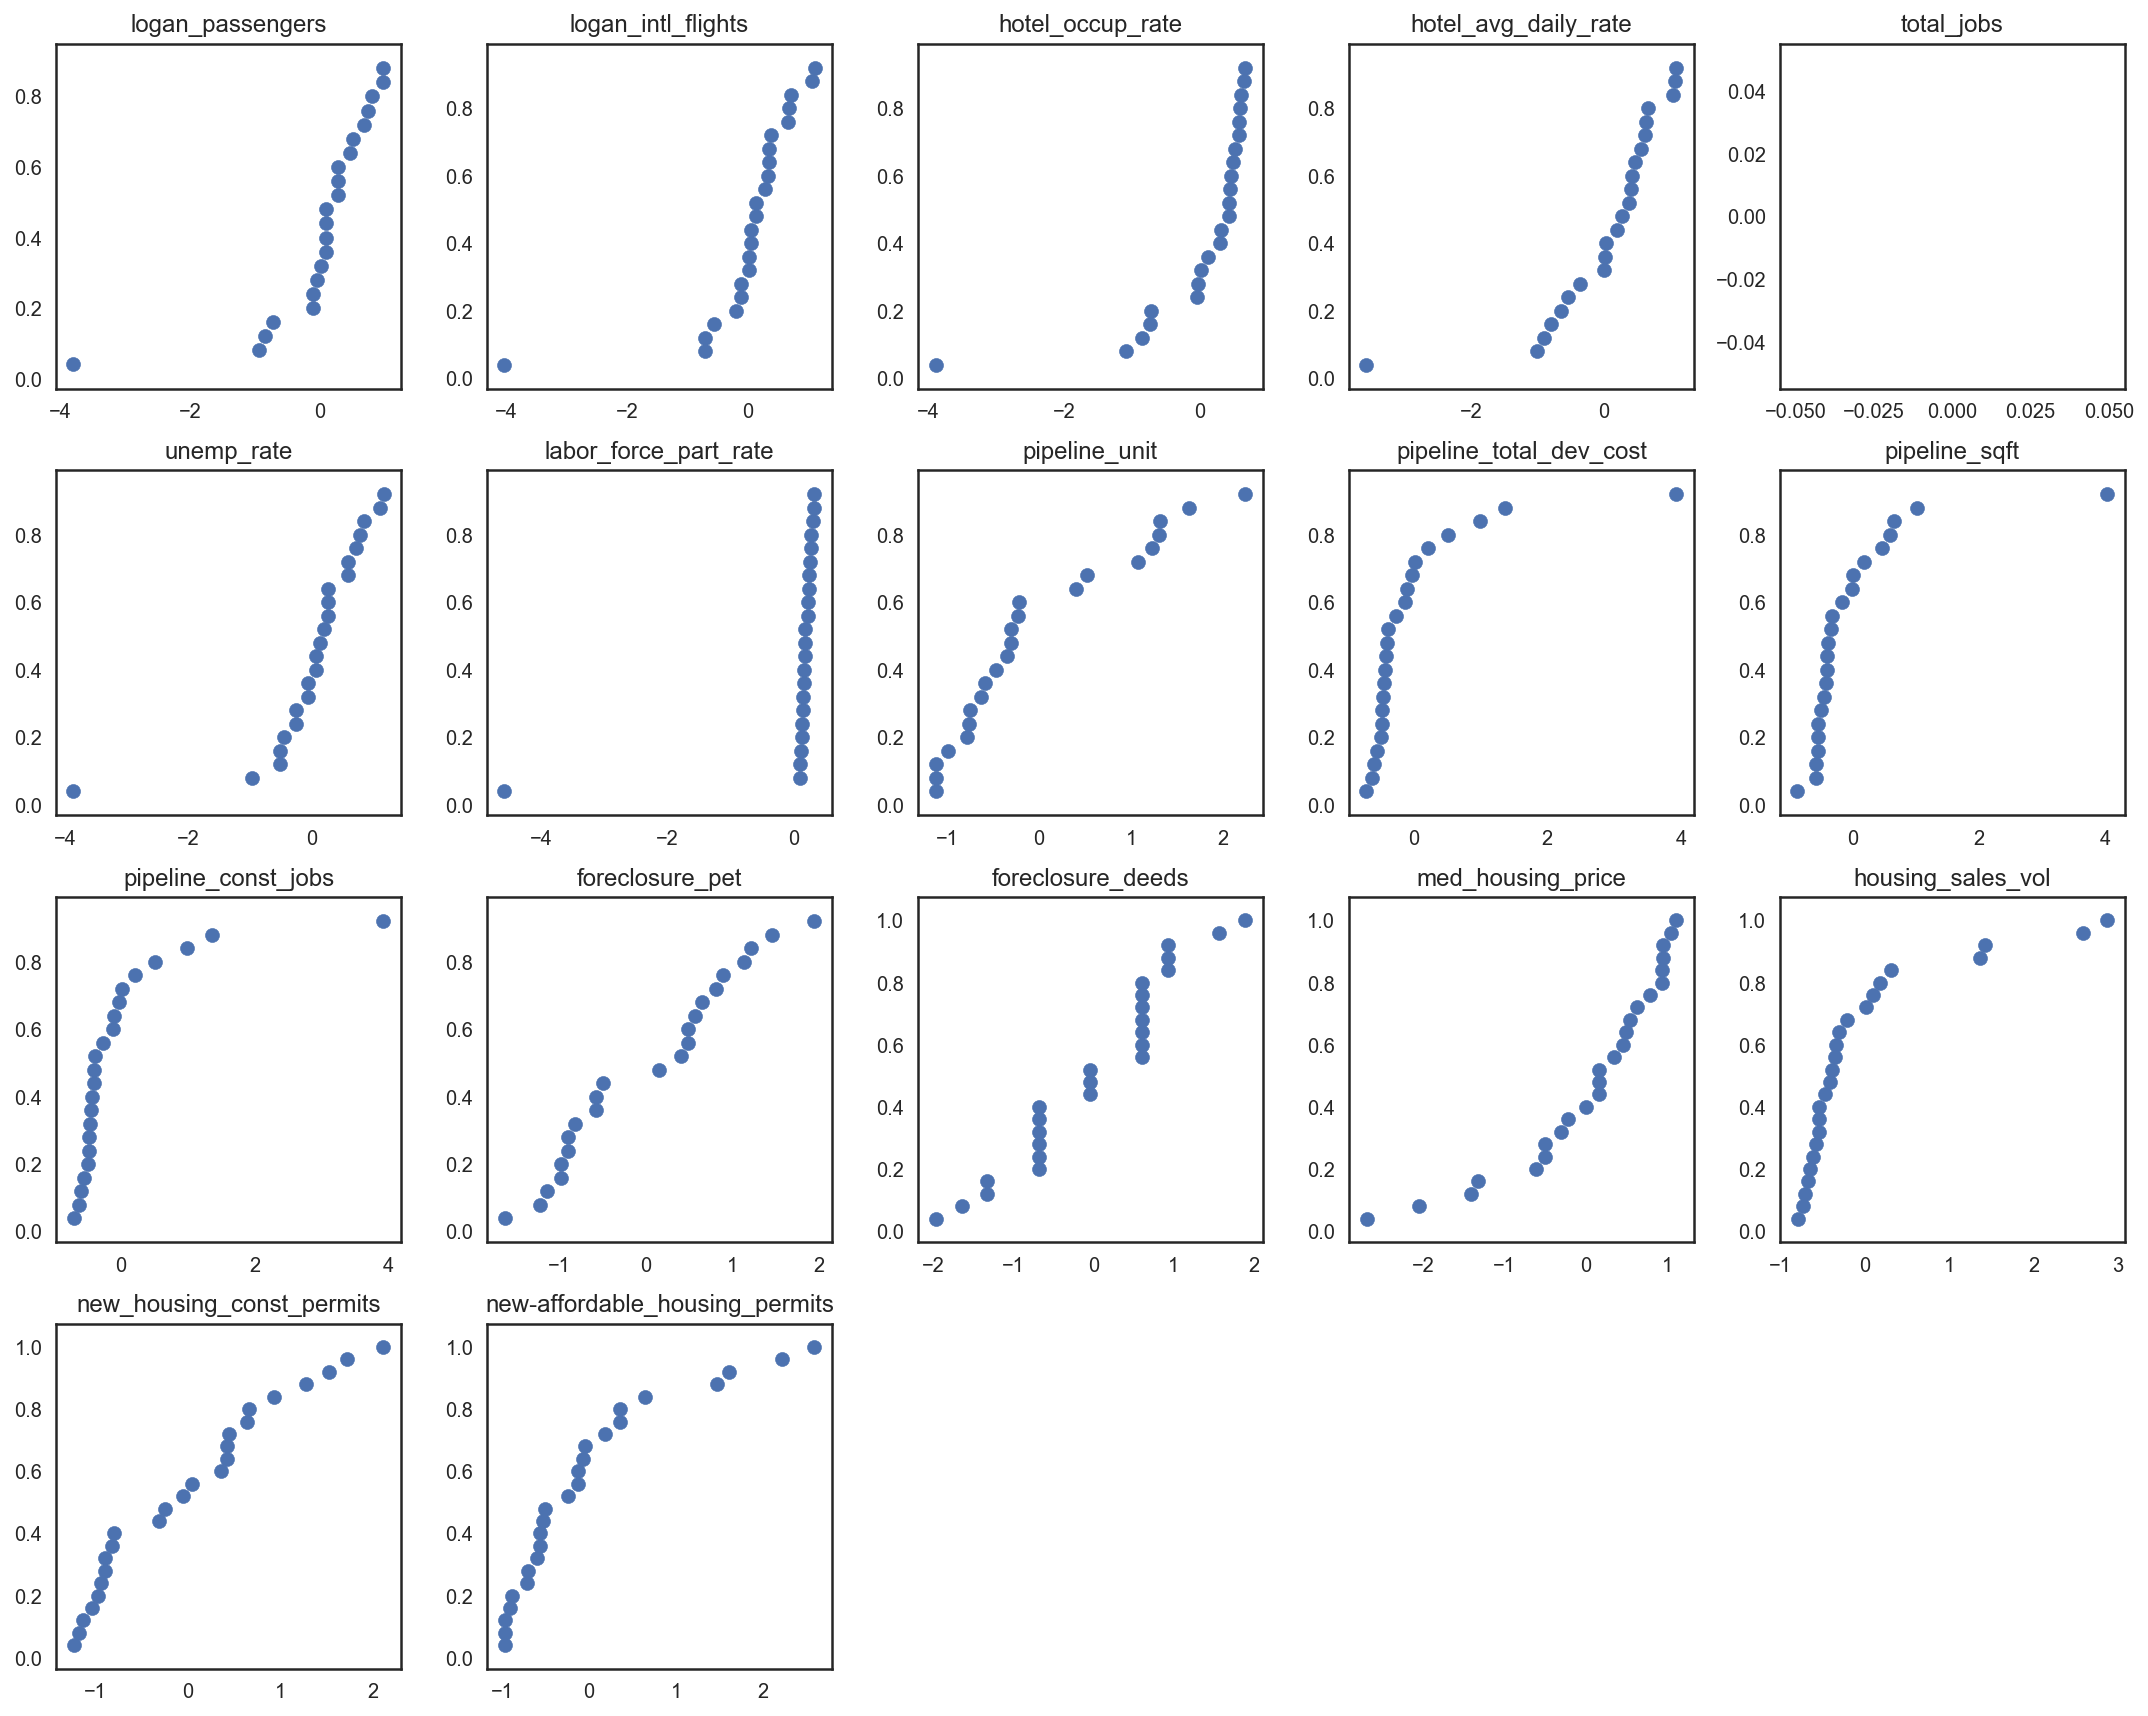

In [25]:
data_cols = [i for i in df.columns if i not in ['Year', 'Month']]
n_rows, n_cols = compute_dimensions(len(data_cols))

fig = plt.figure(figsize=(n_cols*3, n_rows*3))
from matplotlib.gridspec import GridSpec
gs = GridSpec(n_rows, n_cols)
for i, col in enumerate(data_cols):
    ax = plt.subplot(gs[i])
    empirical_cumdist(standard_scaler(df[col]), ax, title=col)
    
plt.tight_layout()
plt.show()

### Exercise

Did we just copy/paste the function?! It's time to stop doing this. Let's refactor the code into a function that can be called.

### Categorical Data

For categorical-type data, we can plot the empirical distribution as well. (This example uses the `smartphone_sanitization.csv` dataset.)

Counter({'phone': 61, 'case': 61, 'junction': 60})


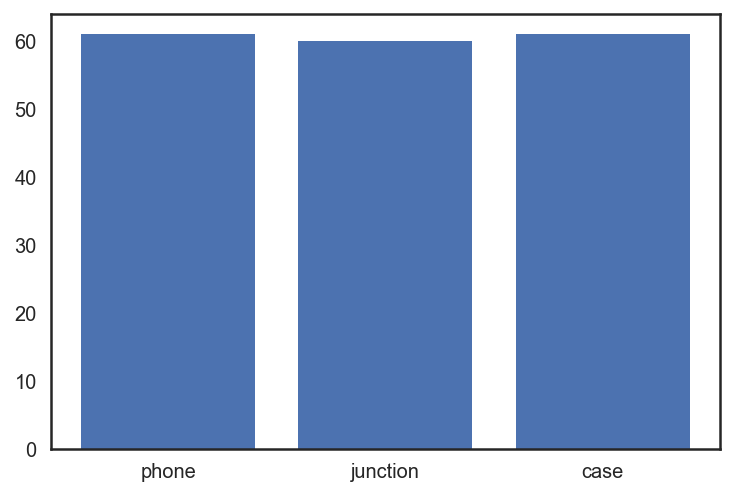

In [15]:
from collections import Counter

def empirical_catdist(data, ax, title=None):
    d = Counter(data)
    print(d)
    x = range(len(d.keys()))
    labels = list(d.keys())
    y = list(d.values())
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

smartphone_df = pd.read_csv('data/smartphone_sanitization.csv')
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
empirical_catdist(smartphone_df['site'], ax=ax)

# Statistical Checks

- Report on deviations from normality.

## Normality?!

- The Gaussian (Normal) distribution is commonly assumed in downstream statistical procedures, e.g. outlier detection.
- We can test for normality by using a K-S test.

## K-S test

From Wikipedia:

> In statistics, the Kolmogorov–Smirnov test (K–S test or KS test) is a nonparametric test of the equality of continuous, one-dimensional probability distributions that can be used to compare a sample with a reference probability distribution (one-sample K–S test), or to compare two samples (two-sample K–S test). It is named after Andrey Kolmogorov and Nikolai Smirnov.

![](https://upload.wikimedia.org/wikipedia/commons/c/cf/KS_Example.png)

In [16]:
from scipy.stats import ks_2samp
import numpy.random as npr

# Simulate a normal distribution with 10000 draws.
normal_rvs = npr.normal(size=10000)
result = ks_2samp(normal_rvs, df['labor_force_part_rate'].dropna())
result.pvalue < 0.05

True

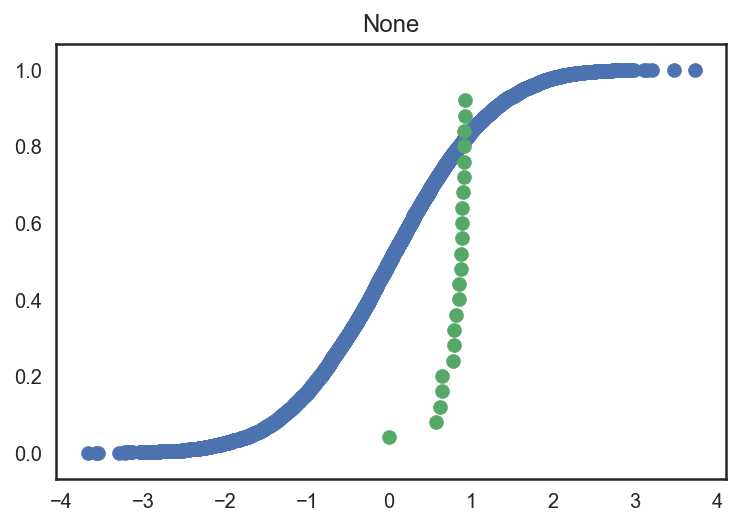

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)
empirical_cumdist(normal_rvs, ax=ax)
empirical_cumdist(df['hotel_occup_rate'], ax=ax)

## Exercise

Re-create the panel of cumulative distribution plots, this time adding on the Normal distribution, and annotating the p-value of the K-S test in the title.

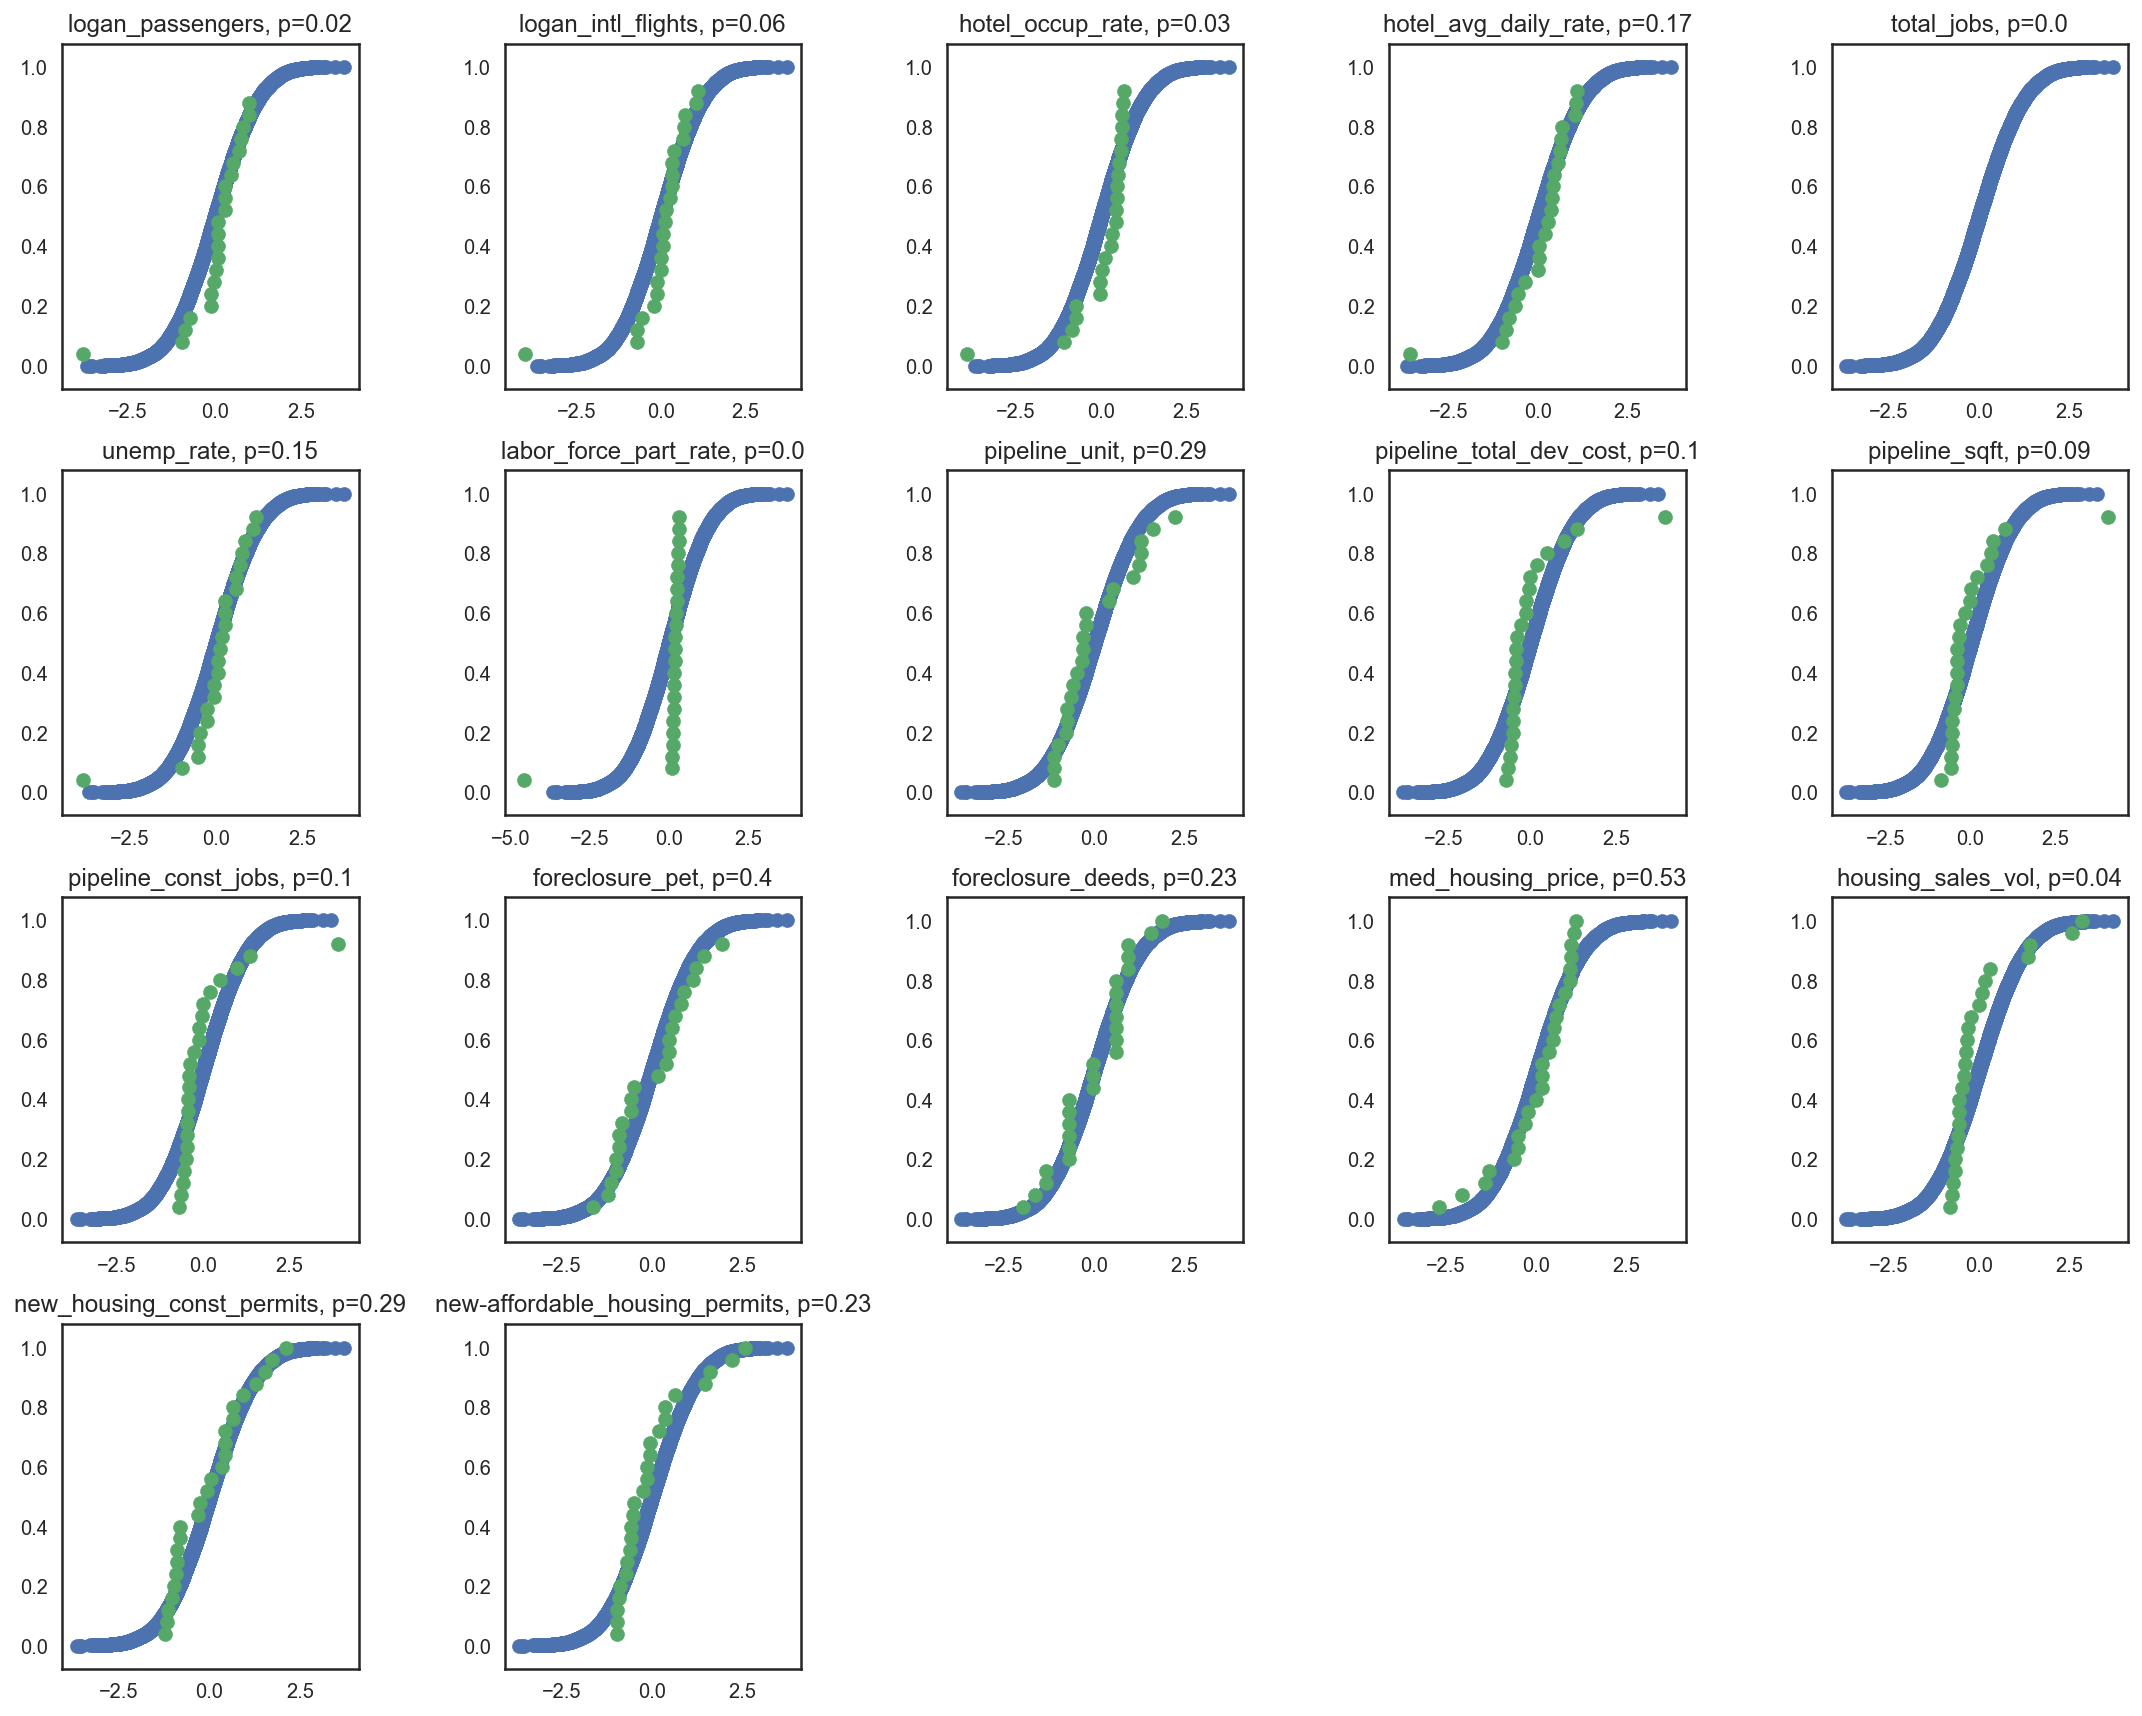

In [36]:
data_cols = [i for i in df.columns if i not in ['Year', 'Month']]
n_rows, n_cols = compute_dimensions(len(data_cols))

fig = plt.figure(figsize=(n_cols*3, n_rows*3))
from matplotlib.gridspec import GridSpec
gs = GridSpec(n_rows, n_cols)
for i, col in enumerate(data_cols):
    ax = plt.subplot(gs[i])
    test = ks_2samp(normal_rvs, standard_scaler(df[col]))
    empirical_cumdist(normal_rvs, ax)
    empirical_cumdist(standard_scaler(df[col]), ax, title=f"{col}, p={round(test.pvalue, 2)}")
    
plt.tight_layout()
plt.show()